In [609]:
import pickle
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


## Import & Prepare data

In [49]:
data = pd.read_csv('../data/covid19_metabolites.csv')

In [50]:
data

,SubjectId,Group,Sex,Age,Creatinine,Glycine,Alanine,Serine,Proline,Valine,...,Hydroxybutyrylcarnitine,Octanoylcarnitine,Decadienoylcarnitine,Decenoylcarnitine,Decanoylcarnitine,Dodecenoylcarnitine,Dodecanoylcarnitine,Hexadecanoylcarnitine,Octadecadienylcarnitine,Octadecenoylcarnitine
0,CV19-0007A,Control,Female,68.0,166.0,230.0,236.0,117.0,151.0,170.0,...,0.2001,0.1216,0.0789,0.2072,0.2437,0.1584,0.1266,0.2262,0.1301,0.2876
1,CV19-0071A,Control,Female,57.0,67.0,233.0,343.0,89.2,151.0,145.0,...,0.0741,0.2256,0.0695,0.2310,0.3679,0.1526,0.1123,0.1534,0.1190,0.2378
2,CV19-0079A,Control,Male,39.0,69.2,250.0,371.0,129.0,175.0,207.0,...,0.0416,0.0951,0.0996,0.1439,0.1661,0.0977,0.0860,0.2005,0.1604,0.3066
3,CV19-0118A,Control,Female,40.0,54.2,190.0,415.0,103.0,165.0,149.0,...,0.0291,0.2326,0.0705,0.2509,0.3039,0.1262,0.0775,0.0983,0.0702,0.1598
4,CV19-0125A,Control,Female,40.0,63.1,189.0,373.0,94.5,167.0,158.0,...,0.0592,0.1857,0.0709,0.2856,0.3549,0.1938,0.1446,0.1281,0.0998,0.2283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,CV19-0830A,Covid,Female,51.0,89.9,117.0,273.0,58.3,125.0,245.0,...,0.1570,0.1348,0.1569,0.2186,0.4441,0.1232,0.0938,0.1326,0.1060,0.2467
227,CV19-0833A,Covid,Male,65.0,112.0,162.0,497.0,88.7,111.0,275.0,...,0.0738,0.2481,0.1557,0.3837,0.6554,0.1521,0.0903,0.1158,0.0797,0.1718
228,CV19-0834A,Covid,Male,66.0,114.0,181.0,574.0,90.8,206.0,247.0,...,0.1481,0.2395,0.1776,0.3464,0.3441,0.2043,0.1211,0.1922,0.1354,0.3183
229,CV19-0932A,Covid,Male,53.0,68.3,321.0,551.0,163.0,219.0,552.0,...,1.0753,0.3273,0.1791,0.4793,0.5729,0.2027,0.1921,0.1784,0.1350,0.3122


### Encoding the target varable

In [18]:
# Split features
X = data.iloc[:, 2:]

In [4]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# encode labels
Y = label_encoder.fit_transform(data['Group'])

In [43]:
dict(zip(list(set(Y)),label_encoder.inverse_transform(list(set(Y)))))

{0: 'Control', 1: 'Covid', 2: 'Recovered'}

### One hot encoding

In [75]:
X = pd.get_dummies(X, columns=['Sex'], prefix='Sex',dtype = float)

In [88]:
X.iloc[:,108:]

,Sex_Female,Sex_Male
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0
...,...,...
226,1.0,0.0
227,0.0,1.0
228,0.0,1.0
229,0.0,1.0


### Train/Test split

In [246]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

In [247]:
print('Train Size:', len(X_train))
print('Test Size:',len(X_test))
# print('Train shape:', X_train.shape, Y_train.shape)
# print('Test shape:', X_test.shape, Y_test.shape)

Train Size: 207
Test Size: 24


### Normalize data

In [248]:
scaler = StandardScaler()
X_train.iloc[:,:-2] = scaler.fit_transform(X_train.iloc[:,:-2])  # Normalize all metabolite and age columns
X_test.iloc[:,:-2] = scaler.transform(X_test.iloc[:,:-2])

In [ ]:
# Y_train_onehot = to_categorical(Y_train, num_classes=3)
# Y_test_onehot = to_categorical(Y_test, num_classes=3)

## tf Neural Network

In [251]:
X_train

,Age,Creatinine,Glycine,Alanine,Serine,Proline,Valine,Threonine,Taurine,Putrescine,...,Decadienoylcarnitine,Decenoylcarnitine,Decanoylcarnitine,Dodecenoylcarnitine,Dodecanoylcarnitine,Hexadecanoylcarnitine,Octadecadienylcarnitine,Octadecenoylcarnitine,Sex_Female,Sex_Male
195,0.732236,1.159811,-0.022317,1.173246,-0.021799,-0.040374,2.513734,0.386976,1.064730,0.049710,...,1.530559,4.252024,5.521950,2.747647,3.728225,1.160574,0.481509,1.089216,0.0,1.0
128,0.732236,-0.459030,1.092637,1.290742,0.821584,3.501601,0.342156,0.410642,2.043261,0.513821,...,-0.464526,-1.071797,-1.036567,0.009476,-0.843296,0.014596,-0.555991,-0.538212,1.0,0.0
88,-0.903203,-0.158312,-0.360181,0.769356,-0.327525,0.630455,-0.119518,0.102975,-0.953731,0.202994,...,-0.127369,-0.876416,-0.828194,-1.045673,-0.923274,-0.223133,-0.438093,-0.735240,0.0,1.0
31,0.823093,0.550427,-0.393968,0.710608,-0.053426,1.354949,0.564444,0.765643,-0.441441,0.060355,...,-0.487580,-1.171263,-1.064443,0.009476,-0.948867,-0.617316,-0.293247,-0.621699,0.0,1.0
114,1.095667,-0.053657,-0.630473,-1.088542,-0.808956,-1.294824,-1.299351,-1.335959,-0.585343,-0.859351,...,-0.069735,0.460460,-0.010731,0.723261,1.076167,-0.511659,-0.429672,-0.413539,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,0.550520,-0.482875,0.957491,0.732638,0.118765,0.040125,-1.846521,1.286310,-0.454872,0.535110,...,0.539260,2.383477,1.870199,2.978377,2.080686,2.426431,1.758172,2.535200,0.0,1.0
97,0.368805,0.052323,-0.067365,0.747325,0.118765,0.469456,0.735434,1.783310,2.369439,3.941426,...,-0.075499,-0.197913,-0.538284,-0.249103,-0.046719,1.321092,1.207422,1.156005,0.0,1.0
123,1.459097,-0.384844,0.079043,-0.412943,0.470175,-0.657536,-0.683786,-0.112391,-0.522026,-0.471882,...,-0.089907,0.332574,0.198338,0.058538,0.394757,-0.215005,0.368664,0.356762,1.0,0.0
120,-0.085484,-0.534540,1.430501,-1.323532,-0.278328,-1.202249,-1.880719,-1.281526,0.090036,-0.731614,...,-0.124487,-0.546046,-0.860948,0.846867,-0.238665,0.254358,0.569090,0.708518,1.0,0.0


In [574]:
# # Model Architecture
# model = Sequential([
#     Dense(128, activation='relu', input_dim=110),
#     # BatchNormalization(),
#     Dropout(0.3),
#     Dense(62, activation='relu',),
#     # BatchNormalization(),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(3, activation='softmax')  # 3 classes for multi-class classification
# ])
# learning_rate=0.0001, early stopping= yes
# Model Architecture
model = Sequential([
    Dense(128, activation='relu', input_dim=110, kernel_regularizer=l2(0.01)),
    # BatchNormalization(),
    # Dropout(0.3),
    Dense(62, activation='relu', kernel_regularizer=l2(0.01)),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 classes for multi-class classification
])

/opt/miniconda3/envs/nndl/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [575]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [576]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

In [577]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=1000,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1771 - loss: 3.9809 - val_accuracy: 0.1667 - val_loss: 3.7972
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2380 - loss: 3.9298 - val_accuracy: 0.2083 - val_loss: 3.7035
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3141 - loss: 3.7253 - val_accuracy: 0.2500 - val_loss: 3.6230
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3135 - loss: 3.7299 - val_accuracy: 0.2917 - val_loss: 3.5514
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3800 - loss: 3.6151 - val_accuracy: 0.4583 - val_loss: 3.4906
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3657 - loss: 3.5679 - val_accuracy: 0.4583 - val_loss: 3.4383
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4604 - loss: 3.4742 - val_accuracy: 0.6250 - val_loss: 3.3925
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 3.4862 - val_accuracy: 0.7083 - val_loss

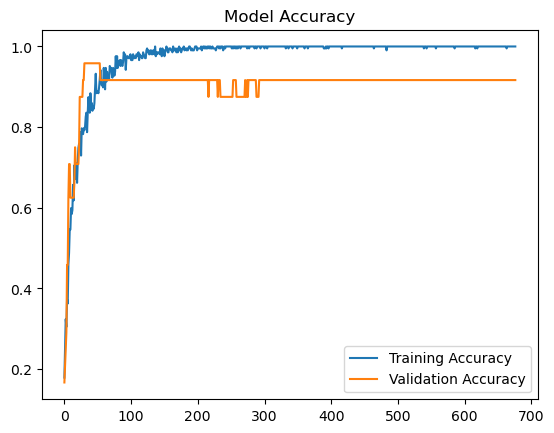

In [578]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

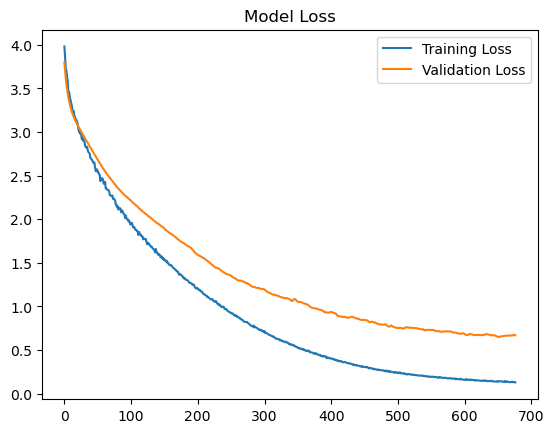

In [580]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Save the entire model (architecture, optimizer, weights)
model.save('../models/tf_model_covid_biomarkers.h5')
model.save('../models/tf_model_covid_biomarkers.keras')

# Save the training history
with open('../analysis/training_history_tf.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save X_train, X_test, Y_train, Y_test as CSV files
pd.DataFrame(X_train).to_csv('../analysis/X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('../analysis/X_test.csv', index=False)
pd.DataFrame(Y_train).to_csv('../analysis/Y_train.csv', index=False)
pd.DataFrame(Y_test).to_csv('../analysis/Y_test.csv', index=False)

### Classification Report

In [607]:
y_pred_probs = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [608]:
# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

In [610]:
# Generate classification report
report = classification_report(Y_test, y_pred, target_names=['Control', 'Covid', 'Recovered'])
print(report)   

              precision    recall  f1-score   support

     Control       0.75      0.75      0.75         4
       Covid       0.93      0.93      0.93        15
   Recovered       1.00      1.00      1.00         5

    accuracy                           0.92        24
   macro avg       0.89      0.89      0.89        24
weighted avg       0.92      0.92      0.92        24



## Feature Importance using SHAP

In [624]:
X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()

In [653]:
explainer = shap.Explainer(model, X_train_array)

shap_values = explainer(X_test_array)

feature_names = X_train.columns

In [654]:
explanation = shap.Explanation(shap_values[0, :, 0], feature_names=feature_names)

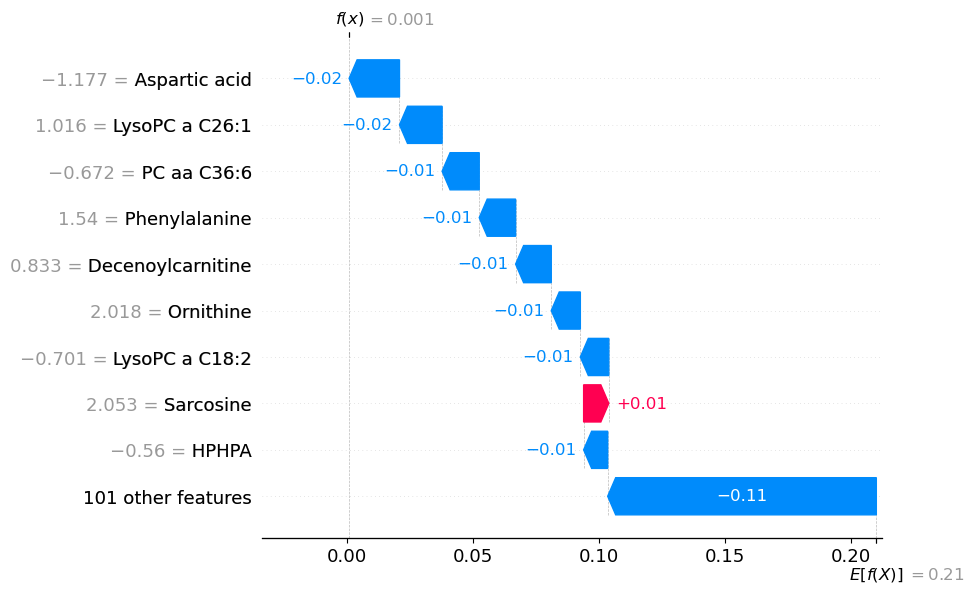

In [662]:
shap.waterfall_plot(explanation, max_display=10)

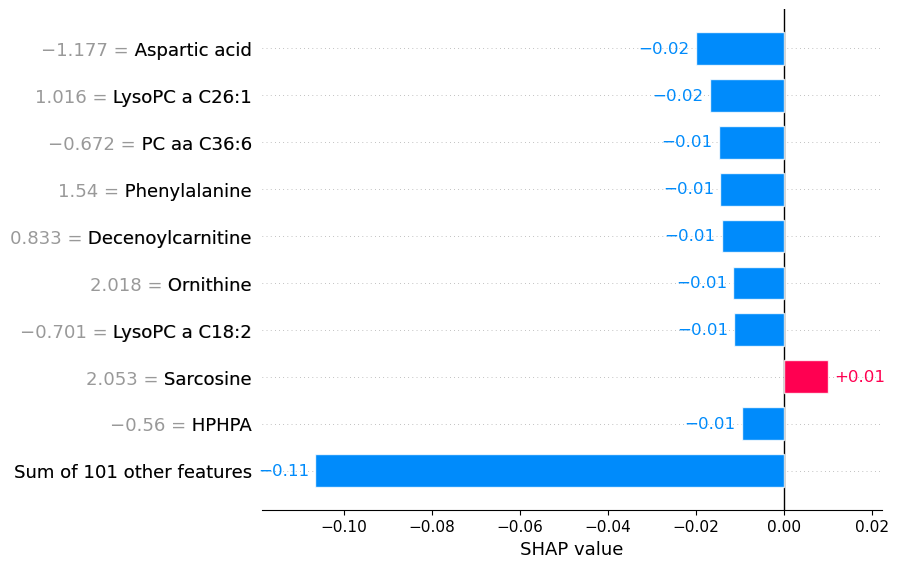

In [ ]:
shap.plots.bar(explanation)

### using permutaion explainer

In [698]:
explainer_p = shap.explainers.Permutation(model.predict, X_test)
shap_values = explainer_p(X_test)

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step 
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 209us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
157/157 ━━━━━━━━━━━━━━━━

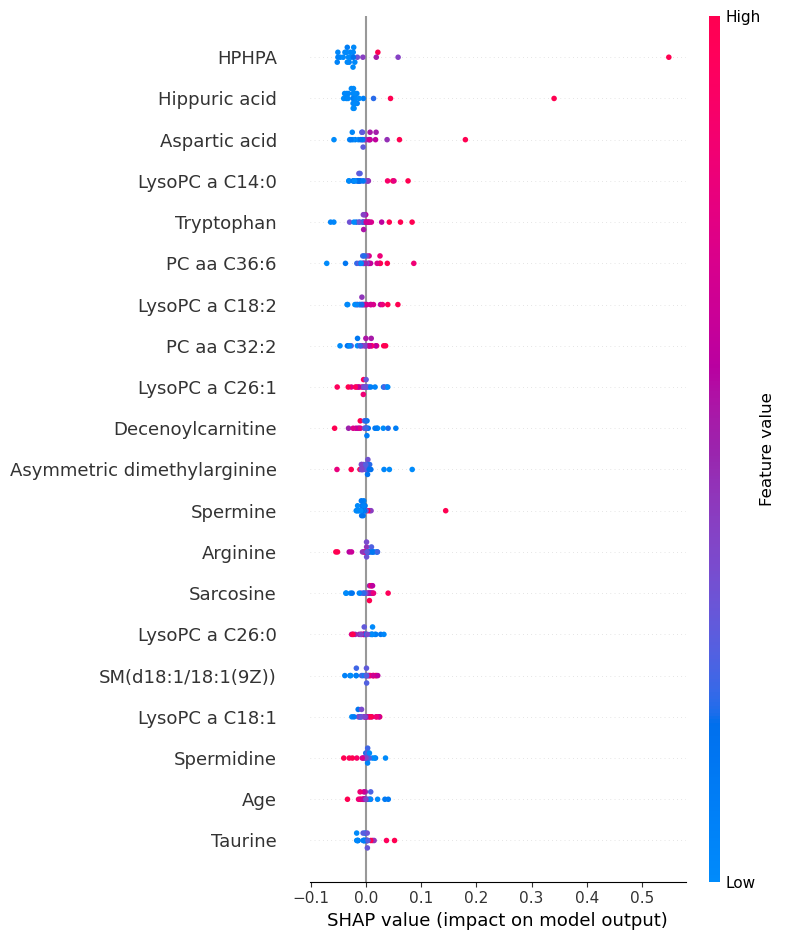

In [701]:
# For Control
shap.summary_plot(shap_values[..., 0], X_test)

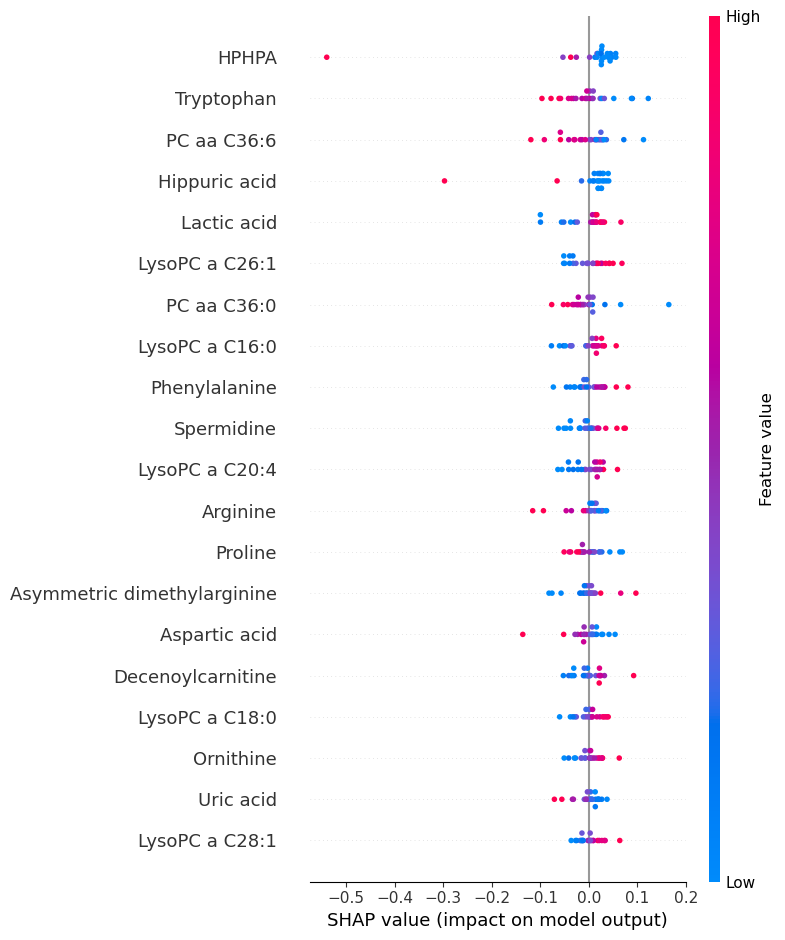

In [702]:
# For Covid
shap.summary_plot(shap_values[..., 1], X_test)

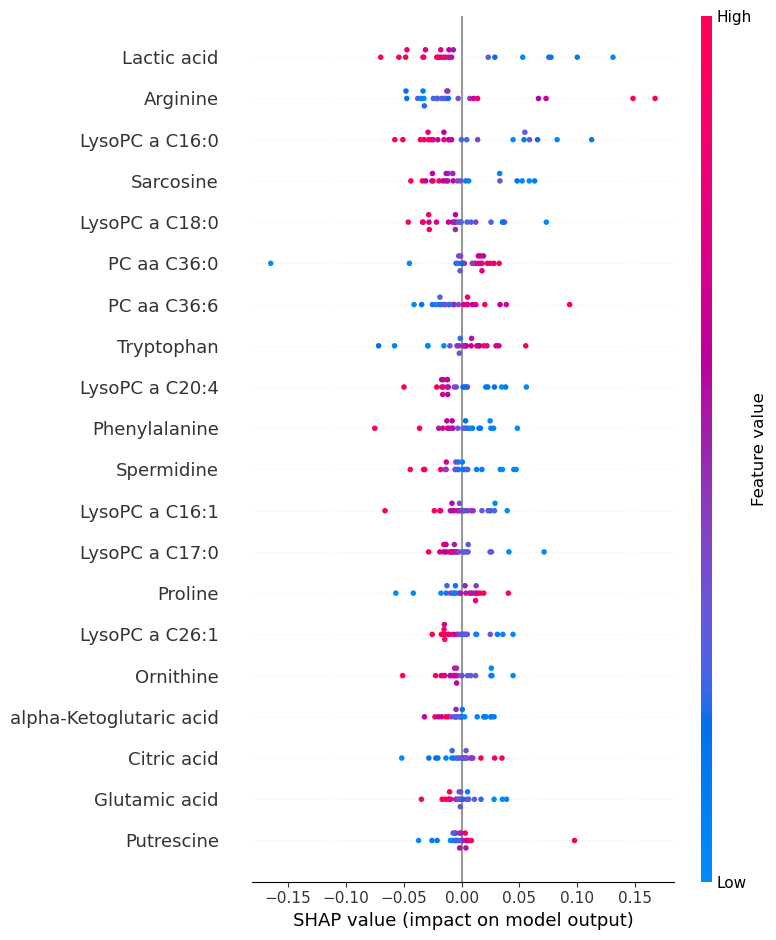

In [703]:
# For Recovered
shap.summary_plot(shap_values[..., 2], X_test)